# GAN Example: Univariate Density Estimation

* _Author_: Sebastian Nowozin (Sebastian.Nowozin@microsoft.com)
* _Date_: 16th July 2018

In [1]:
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
df = 40.0
tdist = scipy.stats.t(df)

Generate training data

In [3]:
ntrain = 5000
Xtrain = tdist.rvs(ntrain)

Plot the training data and the true _probability density function_ (pdf).

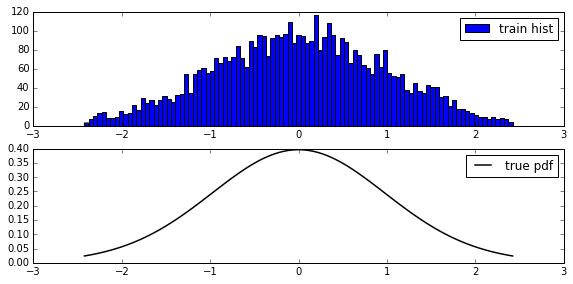

In [4]:
fig, ax = plt.subplots(2,1,figsize=(9.5,4.5))
xmin = tdist.ppf(0.01)
xmax = tdist.ppf(0.99)
xs = np.linspace(tdist.ppf(0.01), tdist.ppf(0.99), 100)
ax[0].hist(Xtrain, xs, label="train hist")
ax[0].legend()
ax[1].plot(xs, tdist.pdf(xs), 'k-', lw=1.5, label="true pdf")
ax[1].legend();

## GAN Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [6]:
class ConjugateDualFunction:
    def __init__(self, divergence_name):
        self.divergence_name = divergence_name

    def T(self, v):
        """Compute T(v) repersentation
        
        Arguments
        v -- The scalar output (full real number range) of the discriminator
        """
        if self.divergence_name == "kl":
            return v
        elif self.divergence_name == "klrev":
            return -F.exp(v)
        elif self.divergence_name == "pearson":
            return v
        elif self.divergence_name == "neyman":
            return 1.0 - F.exp(v)
        elif self.divergence_name == "hellinger":
            return 1.0 - F.exp(v)
        elif self.divergence_name == "jensen":
            return math.log(2.0) - F.softplus(-v)
        elif self.divergence_name == "gan":
            return -F.softplus(-v)
        else:
            raise ValueError("Unknown divergence name in t function.")

    def fstarT(self, v):
        """Compute the f^*(T(v)) representation
        
        Arguments
        v -- The scalar output of the variational function neural network.
        """
        if self.divergence_name == "kl":
            return torch.exp(v - 1.0)
        elif self.divergence_name == "klrev":
            return -1.0 - v
        elif self.divergence_name == "pearson":
            return 0.25*v*v + v
        elif self.divergence_name == "neyman":
            return 2.0 - 2.0*F.exp(0.5*v)
        elif self.divergence_name == "hellinger":
            return F.exp(-v) - 1.0
        elif self.divergence_name == "jensen":
            return F.softplus(v) - math.log(2.0)
        elif self.divergence_name == "gan":
            return F.softplus(v)
        else:
            raise ValueError("Unknown divergence name in fstar_t function.")

In [7]:
class Generator(nn.Module):
    def __init__(self, nhidden):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(1, nhidden)
        self.lin2 = nn.Linear(nhidden, 1)

    def forward(self, z):
        h = F.relu(self.lin1(z))
        x = self.lin2(h)
        return x

class Discriminator(nn.Module):
    def __init__(self, nhidden):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(1, nhidden)
        self.lin2 = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.lin1(x))
        v = self.lin2(h)
        return v

In [8]:
class FGANLearningObjective(nn.Module):
    def __init__(self, gen, disc, divergence_name="gan", gamma=10.0):
        super(FGANLearningObjective, self).__init__()
        self.gen = gen
        self.disc = disc
        self.conj = ConjugateDualFunction(divergence_name)
        self.gammahalf = 0.5*gamma

    def forward(self, xreal, zmodel):
        # Real data
        vreal = self.disc(xreal)    # Real data discriminator output
        Treal = self.conj.T(vreal)  # Mapped to T-space

        # Model data
        xmodel = self.gen(zmodel)   # Map noise to data
        vmodel = self.disc(xmodel)  # Model data discriminator output
        fstar_Tmodel = self.conj.fstarT(vmodel)   # Mapped to f^*(T)

        # Compute generator loss
        loss_gen = -fstar_Tmodel.mean()

        # Compute discriminator loss (negation because we minimize)
        loss_disc = fstar_Tmodel.mean() - Treal.mean()

        # Compute gradient penalty as per (Mescheder et al., ICML 2018)
        if self.gammahalf > 0.0:
            batchsize = xreal.size(0)
            grad_pd = torch.autograd.grad(Treal.sum(), xreal,
                create_graph=True, only_inputs=True)[0]
            grad_pd_norm2 = grad_pd.pow(2)
            grad_pd_norm2 = grad_pd_norm2.view(batchsize, -1).sum(1)
            gradient_penalty = self.gammahalf * grad_pd_norm2.mean()
            loss_disc += gradient_penalty

        return loss_gen, loss_disc

In [37]:
gen = Generator(64)
disc = Discriminator(64)
fgan = FGANLearningObjective(gen, disc, "gan", gamma=1.0)

In [38]:
batchsize = 256
optimizer_gen = optim.Adam(fgan.gen.parameters(), lr=1.0e-3)
optimizer_disc = optim.Adam(fgan.disc.parameters(), lr=1.0e-3)

In [39]:
niter = 25000
for i in range(niter):
    fgan.zero_grad()

    # Generate real data (from known distribution) and noise
    xreal = Variable(torch.Tensor(np.reshape(tdist.rvs(batchsize),
        (batchsize,1))), requires_grad=True)
    zmodel = Variable(torch.rand((batchsize,1)))

    loss_gen, loss_disc = fgan(xreal, zmodel)
    if i % 1000 == 1:
        print("iter %d  obj(D) %.4f  obj(G) %.4f" % (i, loss_disc, loss_gen))

    fgan.gen.zero_grad()
    loss_gen.backward(retain_graph=True)
    optimizer_gen.step()

    fgan.disc.zero_grad()
    loss_disc.backward()
    optimizer_disc.step()

iter 1  obj(D) 1.3662  obj(G) -0.7048
iter 1001  obj(D) 1.0557  obj(G) -0.2876
iter 2001  obj(D) 1.5480  obj(G) -0.9357
iter 3001  obj(D) 1.3811  obj(G) -0.7013
iter 4001  obj(D) 1.3683  obj(G) -0.7075
iter 5001  obj(D) 1.3850  obj(G) -0.7221
iter 6001  obj(D) 1.3922  obj(G) -0.6723
iter 7001  obj(D) 1.3840  obj(G) -0.6563
iter 8001  obj(D) 1.3858  obj(G) -0.6953
iter 9001  obj(D) 1.3873  obj(G) -0.6738
iter 10001  obj(D) 1.3855  obj(G) -0.6657
iter 11001  obj(D) 1.3885  obj(G) -0.7161
iter 12001  obj(D) 1.4034  obj(G) -0.7147
iter 13001  obj(D) 1.3824  obj(G) -0.7015
iter 14001  obj(D) 1.3918  obj(G) -0.6729
iter 15001  obj(D) 1.3808  obj(G) -0.6820
iter 16001  obj(D) 1.3966  obj(G) -0.7093
iter 17001  obj(D) 1.3887  obj(G) -0.6966
iter 18001  obj(D) 1.3821  obj(G) -0.6924
iter 19001  obj(D) 1.4033  obj(G) -0.6977
iter 20001  obj(D) 1.3881  obj(G) -0.7147
iter 21001  obj(D) 1.3804  obj(G) -0.6897
iter 22001  obj(D) 1.3955  obj(G) -0.7084
iter 23001  obj(D) 1.3858  obj(G) -0.6941
iter 

## Visualize model results

In [40]:
n = 4096
Xmodel = fgan.gen(Variable(torch.rand((n,1)), requires_grad=False)).detach().cpu()
Xmodel = Xmodel.numpy()

In [41]:
xmin = min(np.percentile(Xmodel, 1.0), tdist.ppf(0.01))
xmax = max(np.percentile(Xmodel, 99.0), tdist.ppf(0.99))
nbins = 100
xs = np.linspace(xmin, xmax, nbins)
ydisc = fgan.disc(Variable(torch.Tensor(np.reshape(xs, (nbins,1)))))
ydisc = ydisc.detach().cpu().numpy()

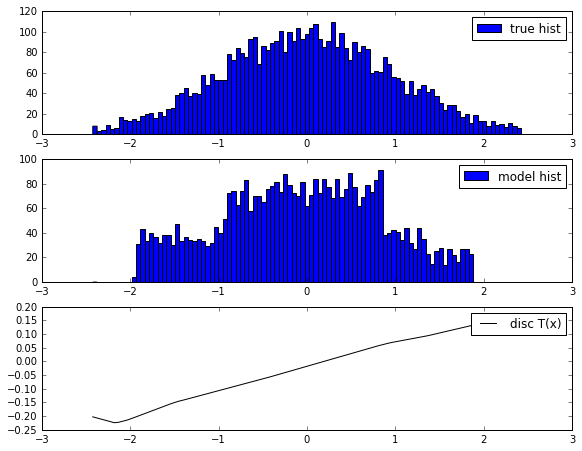

In [42]:
fig, ax = plt.subplots(3,1,figsize=(9.5,7.5))
ax[0].hist(tdist.rvs(ntrain), xs, label="true hist")
ax[0].legend()
ax[1].hist(Xmodel, xs, label="model hist")
ax[1].legend()
ax[2].plot(xs, ydisc, "k-", label="disc T(x)")
ax[2].legend();